Uplift model using meta-learner s-learner for heterogeneous individual treatment effect (ITE) and marketing customer segmentation

# Resources

- [Blog post](https://medium.com/grabngoinfo/s-learner-uplift-model-for-individual-treatment-effect-and-customer-segmentation-in-python-9d410746e122) for this tutorial
- Video version of the tutorial on [YouTube](https://www.youtube.com/watch?v=M2uDcafC4yg&list=PLVppujud2yJqmIwScr4r6_6tekClzdaE6&index=1)
- More video tutorials on [Causal Inference](https://www.youtube.com/playlist?list=PLVppujud2yJoRnQTpHIKVe058uBxKgdWU)
- More blog posts on [Causal Inference](https://medium.com/@AmyGrabNGoInfo/list/causal-inference-633898947606)


For more information about data science and machine learning, please check out my [YouTube channel](https://www.youtube.com/channel/UCmbA7XB6Wb7bLwJw9ARPcYg), [Medium Page](https://medium.com/@AmyGrabNGoInfo) and [GrabNGoInfo.com](https://grabngoinfo.com/tutorials/), or follow GrabNGoInfo on [LinkedIn](https://www.linkedin.com/company/grabngoinfo/).

# Intro

S-learner is a meta-learner that uses a single machine learning model to estimate the individual level causal treatment effect. In this tutorial, we will talk about:
* How to implement s-learner in Python?
* How to make individual treatment effect (ITE) estimation using s-learner?
* How to segment customers based on the individual treatment effect (ITE) estimation?

Let's get started!

# Step 1: Install and Import Libraries

In step 1, we will install and import the python libraries.

Firstly, let's install `causalml` for synthetic dataset creation.

In [ ]:
# Install package
!pip install causalml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 535 kB 34.7 MB/s 
     |████████████████████████████████| 76 kB 5.7 MB/s 
     |████████████████████████████████| 569 kB 79.3 MB/s 
     |████████████████████████████████| 1.8 MB 41.3 MB/s 
     |████████████████████████████████| 722 kB 73.8 MB/s 
     |████████████████████████████████| 115 kB 59.7 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
  Created wheel for causalml: filename=causalml-0.13.0-cp37-cp37m-linux_x86_64.whl size=1293700 sha256=9f4c9e3de4d99fb0d66ed713985009f814dd1699c5c99b3136b9033625606090
  Stored in directory: /root/.cache/pip/wheels/a6/5b/69/42cc8e90cd501e2e912b073ec0747ee8daea28baaf4be0c7b9
Successfully built causalml


After the installation is completed, we can import the libraries.
* `pandas`is imported for data processing.
* `synthetic_data` is imported for synthetic data creation.
* `seaborn` is for visualization.
* `LGBMRegressor` is for the machine learning model training.

In [ ]:
# Data processing
import pandas as pd
import numpy as np

# Create synthetic data
from causalml.dataset import synthetic_data

# Visualization
import seaborn as sns

# Machine learning model
from lightgbm import LGBMRegressor

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


# Step 2: Create Dataset

In step 2, we will create a synthetic dataset for the s-learner uplift model.

* Firstly, a random seed is set to make the synthetic dataset reproducible.
* Then, using the `synthetic_data` method from the `causalml` python package, we created a dataset with five features, one treatment variable, and one continuous outcome variable.
* After that, the dataset is saved in a pandas dataframe.
* Finally, using `value_counts` on the `treatment` variable, we can see that out of 1000 samples, 512 units received treatment and 488 did not receive treatment.

In [ ]:
# Set a seed for reproducibility
np.random.seed(42)

# Create a synthetic dataset
y, X, treatment, _, _, _ = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)

# Save the data in a pandas dataframe
df = pd.DataFrame({'y': y, 'X1': X.T[0], 'X2': X.T[1], 'X3': X.T[2], 'X4': X.T[3], 'X5': X.T[4], 'treatment': treatment})

# Check treatment
df['treatment'].value_counts()

1    512
0    488
Name: treatment, dtype: int64

# Step 3: S-Learner Model Training

In step 3, we will train an s-learner model.

S-learner trains a single machine learning model, and that's why it's called s-learner.
* The model features (a.k.a. predictors or independent variables) include covariates and the treatment variable. We created a variable called `features` that includes `X1`, `X2`, `X3`, `X4`, `X5`, and `treatment`.
* The dependent variable(a.k.a. label) is the outcome variable. We created a variable called `y` that includes the outcome column `y`.

In [ ]:
# Features
features = df.loc[:, ['X1', 'X2', 'X3', 'X4', 'X5', 'treatment']]

# Dependent variable
y = df.loc[:, ['y']]

The model selection and hyperparameter tuning are important for the performance of an s-learner. This is because the model performance affects the model predictions hence the accuracy of the individual treatment effect (ITE) estimation.

Many machine learning model algorithms can be used to build the s-learner. The model algorithms include but are not limited to LASSO regression, Ridge regression, random forest, XGBoost, and a neural network model.

A light GBM model is used in this example, and the process is the same for other machine learning model algorithms.

After initiating the `LGBMRegressor` method, we fit the model using the `features` and the outcome variable.

In [ ]:
# Initiate the light GBM model
s_learner = LGBMRegressor()

# Fit the model
s_learner.fit(features, y)

# Step 4: S-Learner Model Predictions

In step 4, we will make predictions using an s-learner model.

To make the treatment effect estimation, two separate predictions need to be made using the trained model:
* In the first prediction, the `treatment` variable is set to 1 for all the samples. This gives us the predicted outcome values if all the samples received the treatment.
* In the second prediction, the `treatment` variable is set to 0 for all the samples. This gives us the predicted outcome values if none of the samples received the treatment.

In [ ]:
# Set treatment value to 1
with_treatment = features.assign(treatment = 1)

# With treatment predictions
with_treatment_predict = s_learner.predict(with_treatment)

# Set treatment value to 0
without_treatment = features.assign(treatment = 0)

# With treatment predictions
without_treatment_predict = s_learner.predict(without_treatment)

# Step 5: S-Learner Individual Treatment Effect (ITE)

In step 5, we will calculate the individual treatment effect (ITE) using the s-learner predictions.

Individual treatment effect (ITE) is the difference between the predicted outcomes with and without treatment.

After calculating the individual treatment effect (ITE), the data is saved in a dataframe.

In [ ]:
# ITE
ite = with_treatment_predict - without_treatment_predict

# Save ITE data in a pandas dataframe
ite_df = pd.DataFrame({'ITE': ite, 'with_treatment_predict':with_treatment_predict, 'without_treatment_predict': without_treatment_predict})

# Take a look at the data
ite_df.head()

,ITE,with_treatment_predict,without_treatment_predict
0,-0.022509,0.935674,0.958183
1,-0.560047,0.867569,1.427616
2,-0.150755,0.667450,0.818205
3,0.207543,1.372787,1.165244
4,0.134130,0.366198,0.232068


The histogram visualization of the individual treatment effect (ITE) shows a normal distribution.

* The average treatment effect is around 0.5.
* Most individuals in the dataset have a positive treatment effect.
* Some individuals have negative treatment effects.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52fe6ceed0>]],
      dtype=object)

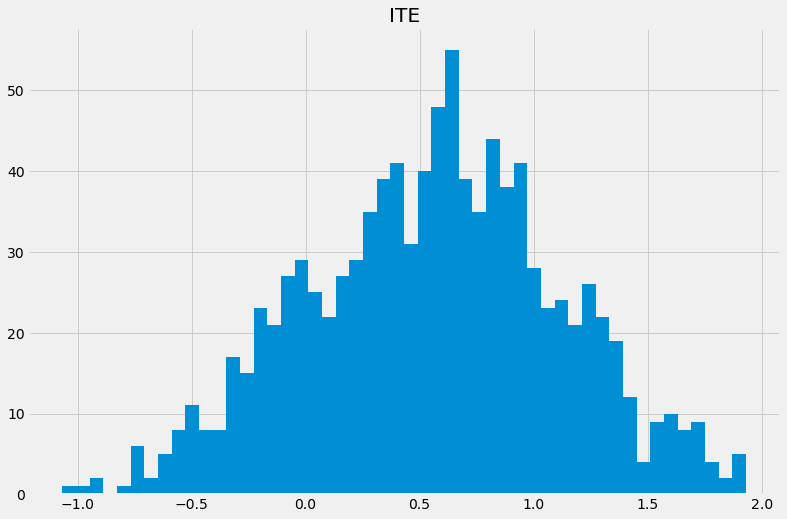

In [ ]:
# visualization
ite_df.hist(column ='ITE', bins=50, grid=True, figsize=(12, 8))

# Step 6: S-Learner Average Treatment Effect (ATE)

In step 6, we will estimate the average treatment effect (ATE) using the s-learner predictions.

The average treatment effect (ATE) for the population is the average of the individual treatment effect (ITE). We can see that the average treatment effect (ATE) is 0.47.

To learn more about the definition and calculation for the average treatment effect (ATE), please check out my previous tutorial [ATE vs CATE vs ATT vs ATC for Causal Inference](https://medium.com/grabngoinfo/ate-vs-cate-vs-att-vs-atc-for-causal-inference-998a577f2f8c).


In [ ]:
# Calculate ATE
ATE = ite.mean()

# Print out results
print(f'The average treatment effect (ATE) is {ATE:.2f}')

The average treatment effect (ATE) is 0.47


# Step 7: Customer Segmentation Using S-Learner Individual Treatment Effect (ITE)

In step 7, we will talk about how to segment customers using individual treatment effect (ITE) from the s-learner.

An uplift model divides customers into four groups based on the incremental change caused by the intervention. A common use of the uplift model is for marketing campaigns. The common treatments in a marketing campaign can be emails, displays, and promotions.
* **Persuadables** are those who buy with treatment and do not buy without treatment.
* **Lost Causes** are those who do not buy with or without treatment.
* **Sure Things** are those who buy with or without treatment.
* **Sleeping Dogs** are those who buy without treatment and do not buy with treatment.

Based on the uplift model customer segmentation, we divide the individuals into three groups using their individual treatment effect (ITE).
* `sleeping-dog` is a segment with the individual treatment effect (ITE) less than -0.5. These are customers who would have made the purchase if they did not receive and get annoyed by the marketing messages.
* `persuadable` is a segment with the individual treatment effect (ITE) greater than 0.5. These are customers who would have made the purchase if they receive the marketing messages, but would not make the purchase if they did not receive the marketing messages.
* `no_impact` is a segment with the individual treatment effect (ITE) between -0.5 and 0.5. Because their individual treatment effects (ITE) are close to 0, we consider the marketing messages do not have any impact on their purchasing decisions. This segment includes both lost causes and sure things groups.

In [ ]:
# Create the segmentation function
def segmentation(x):
  if x < -0.5:
    return 'sleeping-dog'
  elif x > 0.5:
    return 'persuadable'
  else:
    return 'no_impact'

# Apply the function
ite_df['segment'] = ite_df['ITE'].apply(segmentation)

# Take a look at the data
ite_df.head()

,ITE,with_treatment_predict,without_treatment_predict,segment
0,-0.022509,0.935674,0.958183,no_impact
1,-0.560047,0.867569,1.427616,sleeping-dog
2,-0.150755,0.667450,0.818205,no_impact
3,0.207543,1.372787,1.165244,no_impact
4,0.134130,0.366198,0.232068,no_impact


After creating the customer segments, we created a column in the dataframe. The visualization of the segments shows that nearly half of the individuals are persuadable, very few individuals are sleeping dogs, and more than half of people are not impacted by marketing campaigns.

These segments can help optimize the marketing strategies and increase the return on investment (ROI).

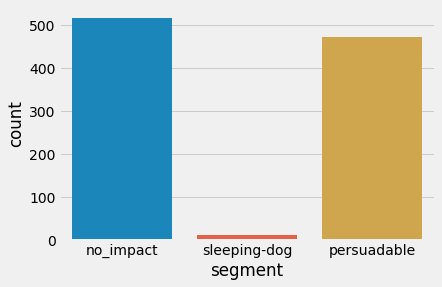

In [ ]:
# Visualization
sns.countplot(x=ite_df['segment'])

If you prefer to use a python package instead of manually building an S-learner, please check out the tutorial [Explainable S-Learner Uplift Model Using Python Package CausalML](https://medium.com/grabngoinfo/explainable-s-learner-uplift-model-using-python-package-causalml-a3c2bed3497c)

# Recommended Tutorials

- [GrabNGoInfo Machine Learning Tutorials Inventory](https://medium.com/grabngoinfo/grabngoinfo-machine-learning-tutorials-inventory-9b9d78ebdd67)
- [ATE vs CATE vs ATT vs ATC for Causal Inference](https://medium.com/grabngoinfo/ate-vs-cate-vs-att-vs-atc-for-causal-inference-998a577f2f8c)
- [Explainable S-Learner Uplift Model Using Python Package CausalML](https://medium.com/grabngoinfo/explainable-s-learner-uplift-model-using-python-package-causalml-a3c2bed3497c)
- [Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/time-series-causal-impact-analysis-in-python-63eacb1df5cc)
- [3 Ways for Multiple Time Series Forecasting Using Prophet in Python](https://medium.com/p/3-ways-for-multiple-time-series-forecasting-using-prophet-in-python-7a0709a117f9)
- [Four Oversampling And Under-Sampling Methods For Imbalanced Classification Using Python](https://medium.com/p/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037)
- [Multivariate Time Series Forecasting with Seasonality and Holiday Effect Using Prophet in Python](https://medium.com/p/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57)
- [Time Series Anomaly Detection Using Prophet in Python](https://medium.com/grabngoinfo/time-series-anomaly-detection-using-prophet-in-python-877d2b7b14b4)
- [Autoencoder For Anomaly Detection Using Tensorflow Keras](https://pub.towardsai.net/autoencoder-for-anomaly-detection-using-tensorflow-keras-7fdfa9f3ad99)
- [Databricks Mount To AWS S3 And Import Data](https://medium.com/grabngoinfo/databricks-mount-to-aws-s3-and-import-data-4100621a63fd)
- [Hyperparameter Tuning For XGBoost](https://medium.com/p/hyperparameter-tuning-for-xgboost-91449869c57e)
- [One-Class SVM For Anomaly Detection](https://medium.com/p/one-class-svm-for-anomaly-detection-6c97fdd6d8af)
- [Sentiment Analysis Without Modeling: TextBlob vs. VADER vs. Flair](https://medium.com/p/sentiment-analysis-without-modeling-textblob-vs-vader-vs-flair-657b7af855f4)
- [Recommendation System: User-Based Collaborative Filtering](https://medium.com/p/recommendation-system-user-based-collaborative-filtering-a2e76e3e15c4)
- [How to detect outliers | Data Science Interview Questions and Answers](https://medium.com/p/how-to-detect-outliers-data-science-interview-questions-and-answers-1e400284f6b4)
- [Causal Inference One-to-one Matching on Confounders Using R for Python Users](https://medium.com/grabngoinfo/causal-inference-one-to-one-matching-on-confounders-using-python-and-r-1baf7fb105f3)
- [Gaussian Mixture Model (GMM) for Anomaly Detection](https://medium.com/grabngoinfo/gaussian-mixture-model-gmm-for-anomaly-detection-e8360e6f4009)
- [Time Series Anomaly Detection Using Prophet in Python](https://medium.com/p/time-series-anomaly-detection-using-prophet-in-python-877d2b7b14b4)
- [How to Use R with Google Colab Notebook](https://medium.com/p/how-to-use-r-with-google-colab-notebook-610c3a2f0eab)

# References

* Lo, V. S. Y. (2002); The True Lift Model, ACM SIGKDD Explorations Newsletter, Vol. 4, No. 2, 78–86, available at http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=4FD247B4987CBF2E29186DACE0D40C3D?doi=10.1.1.99.7064&rep=rep1&type=pdf
* [CausalML documentation](https://github.com/uber/causalml/)